In [2]:
import numpy as np
import matplotlib.pyplot as plt

2. Construct a natural cubic spline to approximate $f(x) = \sin(\pi x)$ by using the values at 𝑥 = 0,0.25,0.5,0.75 and 1.0. Integrate the spline over $[0,1]$ and compare to the analytic answer. Use the derivatives of the spline to approximate 𝑓′(0.5) and 𝑓″(0.5). Compare to the analytic values.

In [3]:
#reorganizing our data for myself
xvalues = [0, 0.25, 0.5, 0.75, 1.0]
sinx = [0, np.sin(0.25*np.pi), 1, np.sin(0.75*np.pi), 0]

Let's rename the values $\{x_0, ..., x_4\}$, and note that $f(x_0) = f(x_4) = 0, f'(x_2) = 0$ and $f(x_2) = 1$. Our cubic spline consists of the four cubic polynomials:
$S_i(x)$, each defined on the interval $[x_i, x_{i+1}]$ for $i = 0 ... 3$.
We'll set the natural boundary conditions that $S_0''(x_0) = S_4''(x_0) = 0$ as this would agree with how the function $f(x) = \sin(\pi x)$ behaves.

As was done in class, let's do all our work in terms of the unknowns $y_i'' = S''(x_i)$, so $y_0'' = y_4'' = 0$. Considering the second derivative of the $S_i$, we got:
$$S_i''(x) = y_i''\frac{x_{i+1}-x}{h} + y_{i+1}''\frac{x - x_i}{h} \text{ for } i = 0,...3$$
Note that since out points are evenly spaced I'm not indexing $h$. Integration twice yields that 
$$ S_i(x) = \frac{y_i''}{6h}(x_{i+1}-x) + \frac{y''_{i+1}}{6h}(x - x_{i}) + c_i(x_{i+1}-x) + d_i(x - x_i)$$
for some constants $c_i, d_i$. Solving for these we get the equations: 
$$ c_i = \frac{f_{i+1}}{h} - y_{i+1}''\frac{h}{6} \quad \text{ and }\quad  
    d_i = \frac{f_i}{h} - y_i''\frac{h}{6} $$
Moving along, as was done in class, we end up with the wonderful system of linear equations that can be expressed in matrix form as follows, noting that $h_i = h = 1/4$ and $\gamma_i = \gamma = 1$ for all $i = 0,...3$:
$$ \begin{pmatrix} 1 & 1/4 & 0 \\ 1/4 & 1 & 1/4 \\ 0 & 1/4 & 1 \end{pmatrix}\cdot
\begin{pmatrix} y_1'' \\ y_2'' \\ y_3'' \end{pmatrix} = 
24\begin{pmatrix} 1-\sqrt{2} \\ \sqrt{2}-2 \\ 1-\sqrt{2} \end{pmatrix}
\quad \text{ where } b_i = 24(f_{i+1} + f_{i-1} - 2f_i) $$
We can easily solve this system of equations using some numerical python tools:

In [4]:
A = np.array([[1, 0.25, 0], [0.25, 1, 0.25], [0, 0.25, 1]])
B = np.array([24*(1-np.sqrt(2)), 24*(np.sqrt(2)-2), 24*(1-np.sqrt(2))])
Y = np.linalg.inv(A).dot(B)
print(Y)

[ -7.344465   -10.38664201  -7.344465  ]


In [5]:
Ylist = [0, Y[0], Y[1], Y[2], 0]
print(Ylist)
C = []
D = []
for i in range(4) :
    c = sinx[i]*4 - Ylist[i]/24
    C.append(c)
    d = sinx[i+1]*4 - Ylist[i+1]/24
    D.append(d)
print(C)
print(D)

[0, -7.344464995648976, -10.38664200522123, -7.344464995648976, 0]
[0.0, 3.134446499564897, 4.432776750217551, 3.1344464995648975]
[3.134446499564897, 4.432776750217551, 3.1344464995648975, 0.0]


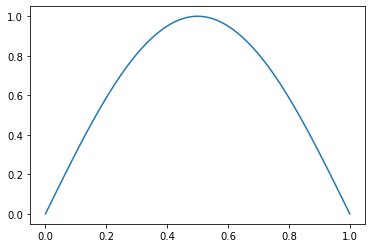

In [8]:
for i in range(4):
    def S(i,x):
        s = Ylist[i]*(2/3)*((xvalues[i+1] - x)**3) + Ylist[i+1]*(2/3)*((x - xvalues[i])**3)
        t = C[i]*(xvalues[i+1] - x) + D[i]*(x - xvalues[i])
        return (s + t)
def Spline(x):
    if (0 <= x <= 0.25):
        return S(0,x)
    elif (0.25 < x <= 0.5):
        return S(1,x)
    elif (0.5 < x <= 0.75):
        return S(2,x)
    elif (0.75 < x <= 1):
        return S(3,x)

L = np.arange(0,1.01,.01)
K = []
J = []
for i in range(101):
    x = L[i]
    K.append(Spline(x))
#print(L)
#print(K)
plt.plot(L,K)

In [9]:
#Now to integrate the spline we'll use the gaussian quadrature method that python has built in.
import scipy.integrate as integrate
I = integrate.quad(Spline, 0, 1)
print(I)

(0.6362038749637413, 7.063292550672784e-15)


The first output is the calculated integral and the second is an estimate of the error on it. This error isn't the one we care about though, because a priori, the computer has no idea we're trying to approximate sine. The analytic value can be calculated easily:
$$ \int_0^1 \sin(\pi x)dx = \left.-\frac{\cos(\pi x)}{\pi}\right|^1_0 = \frac{2}{\pi}$$

In [10]:
error = np.abs(2/np.pi - I[0])
print(error)

0.0004158974038400709


One sees here that the spline made for a very good approximation of the function, as the integrals differ by less than .001, meaning the functions do not deviate from each other in a meaningful way.

Next we need to use the derivative of this spline to approximate some values. I could use the build in differentiation methods in python, but in our construction of the spline we already used the first and second derivatives so I'll just redefine them here:

In [41]:
for i in range(4):
    def Ss(i, x):
        temp = -2*Ylist[i]*((xvalues[i+1]-x)**2) + 2*Ylist[i+1]*((x-xvalues[i])**2) + C[i] - D[i]
        return temp
    def Sss(i, x):
        temp = 4*Ylist[i]*(xvalues[i+1] - x) + 4*Ylist[i+1]*(x - xvalues[i])
        return temp

    
def FirstDeriv(x):
    if (0 <= x <= 0.25):
        return Ss(0,x)
    elif (0.25 < x < 0.5):
        return Ss(1,x)
    elif (0.5 <= x <= 0.75):
        return Ss(2,x)
    elif (0.75 < x <= 1):
        return Ss(3,x)
def SecondDeriv(x):
    if (0 <= x <= 0.25):
        return Sss(0,x)
    elif (0.25 < x <= 0.5):
        return Sss(1,x)
    elif (0.5 < x <= 0.75):
        return Sss(2,x)
    elif (0.75 < x <= 1):
        return Sss(3,x)

print(FirstDeriv(0.5))
print(SecondDeriv(0.5))

#from scipy.misc import derivative
#derivative(Spline, 0.5, dx = 1e-6)

2.5966605013053075
-10.38664200522123


At first glance these look super funky, and they do differ significantly from the analytical values of 0 and $-\pi^2$, but we don't require that these match in the construction of the cubic splines. We just require the boundary conditions and that the derivatives of the piecewise polynomials agree on the nodes. The second derivative isn't even that far off, which might be because we defined the piecewise polynomials in terms of the second derivatives.